### Test handle of precursor and predictor dataframes
This testcase comes out of the params experiments to optimize the role:
* significance testing (alpha)
* min_samples in DBSCAN
* eps in DBSCAN

Currently the regions cannot be too big: memory errors
I got a working pipeline for z300: with alpha 0.0005, eps 1200, minsamples 1000

In [26]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
basedir = Path('/scistor/ivm/jsn295/paramtest/dbscan/eps1200_ms1000/')
precfile = basedir / 'precursor.multiagg.parquet'
predfile = basedir / 'response.multiagg.trended.parquet'

In [3]:
precs = pd.read_parquet(precfile)
preds = pd.read_parquet(predfile)

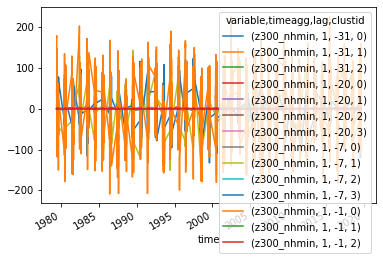

In [12]:
precs.loc[preds.index,:].plot()

In [41]:
precs.shape

(7544, 14)

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.signal import detrend

In [22]:
# Data
X = precs.loc[preds.index,(slice(None),slice(None),-7,slice(None))] # Training at lag -7. Single model
y = preds.iloc[:,2] # Output is the 5 daily average t2m (non-detrended I believe)
y_det = pd.Series(detrend(y), index  = y.index)

In [38]:
# Train a good RandomForest
# Check if we can do hyperparameter optimization.
from sklearn.model_selection import KFold
leaf_sizes = np.arange(1,800,20)
n_folds = 8
results = xr.DataArray(np.empty((len(leaf_sizes),n_folds,2)), dims = ('leaf_size','fold','metric'), coords = dict(leaf_size = leaf_sizes, fold = np.arange(n_folds),metric = ['r2','mse']))
for ind, alpha in enumerate(leaf_sizes):
    kf = KFold(n_splits=n_folds)
    k = 0
    for train_index, val_index in kf.split(X):
        X_t_fold, X_v_fold = X.iloc[train_index], X.iloc[val_index]
        y_t_fold, y_v_fold = y_det.iloc[train_index], y_det.iloc[val_index]
        regr = RandomForestRegressor(min_samples_leaf = alpha)
        regr.fit(X_t_fold,y_t_fold)
        predictions = regr.predict(X_v_fold)
        r2 = r2_score(y_v_fold, predictions)
        mse = mean_squared_error(y_v_fold, predictions)
        results[ind,k,:] = [r2, mse]
        k += 1

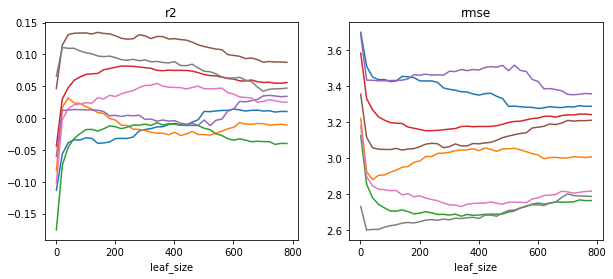

In [39]:
df = results.to_dataframe(name = 'score').unstack([1,2])
df.columns = df.columns.droplevel(0)
fig, [ax1,ax2] = plt.subplots(ncols=2, figsize = (10,4))
df.loc[:,(slice(None),'r2')].plot(ax = ax1, legend = False, title = 'r2')
df.loc[:,(slice(None),'mse')].plot(ax = ax2, legend = False, title = 'rmse')

In [31]:
# So the model should have leaf_size = 200

regr_forest = RandomForestRegressor(min_samples_leaf = 200)
regr_forest.fit(X = X, y = y)

def single_pass_forward_permute(classifier, data_in, data_out, scores = [r2_score, mean_squared_error], scorenames = ['r2','mse']):
    outcomes = pd.DataFrame(index = data_in.columns, columns = pd.Index(scorenames,name = 'score'))
    for variable in data_in.columns:
        temp = data_in.copy() # Make sure that we are not overwriting by reference
        temp[variable] = temp[variable].sample(n = len(temp), replace = False).values
        prediction = classifier.predict(X = temp) # Prediction for positive, which is lightning
        outcomes.loc[variable] = [score(data_out, prediction) for score in scores]
    # Add the reference forecast:
    prediction = classifier.predict(X = data_in)
    outcomes.loc['reference'] = [score(data_out, prediction) for score in scores]
    return outcomes
train_perm = single_pass_forward_permute(regr_forest, X, y)

In [37]:
train_perm

score,r2,mse
"(z300_nhmin, 1, -7, 0)",0.101883,3.19245
"(z300_nhmin, 1, -7, 1)",-0.035663,3.68137
"(z300_nhmin, 1, -7, 2)",0.100565,3.19713
"(z300_nhmin, 1, -7, 3)",0.0659045,3.32033
reference,0.103219,3.18769
